In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
from scipy.linalg import qr_insert, qr

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import data_index
from desc.coils import SplineXYZCoil
from desc.equilibrium import *
from desc.examples import get
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import factorize_linear_constraints
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import Optimizer
from desc.perturbations import *
from desc.profiles import PowerSeriesProfile

from desc.utils import copy_coeffs, svd_inv_null

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic

DESC version 0.12.3+459.gc82039e86.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.35, dtype=float64
Using device: CPU, with 8.95 GB available memory


In [4]:
def set_poincare_equilibrium(eq):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

In [5]:
eq0 = get("HELIOTRON")
eq = eq0.copy()

In [11]:
R_modes = eq.R_basis.modes[eq.R_basis.modes[:, 2] == 0][:,:2]
R_lmn = eq.R_lmn[eq.R_basis.modes[:, 2] == 0]

Z_modes = eq.Z_basis.modes[eq.Z_basis.modes[:, 2] == 0][:,:2]
Z_lmn = eq.Z_lmn[eq.Z_basis.modes[:, 2] == 0]

L_modes = Z_modes
L_lmn = np.zeros_like(Z_lmn)

section = ZernikeRZLToroidalSection(
    modes_R=R_modes,
    R_lmn=R_lmn,
    modes_Z=Z_modes,
    Z_lmn=Z_lmn,
    modes_L=L_modes,
    L_lmn=L_lmn,
)

eq_poincare = Equilibrium(
    xsection=section,
    pressure=eq.pressure,
    iota=eq.iota,
    Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
    NFP=eq.NFP,  # number of field periods
    L=eq.L,  # radial spectral resolution
    M=eq.M,  # poloidal spectral resolution
    N=eq.N,  # toroidal spectral resolution
    L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
    M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
    N_grid=eq.N_grid,  # real space toroidal resolution
    sym=eq.sym,  # explicitly enforce stellarator symmetry
    spectral_indexing=eq._spectral_indexing,
)

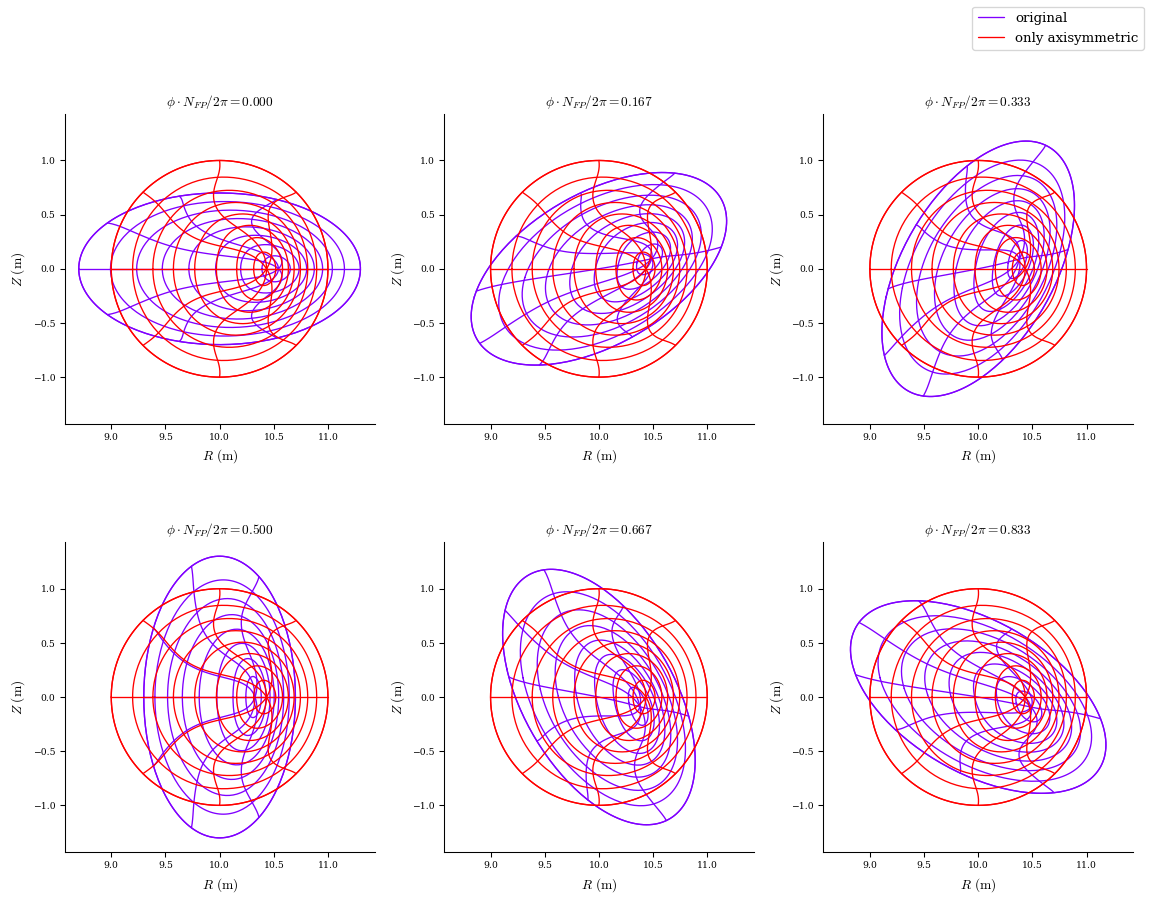

In [12]:
plot_comparison(eqs=[eq0, eq_poincare], labels=["original", "only axisymmetric"]);

In [19]:
def solve_step(eq_poin, maxiter=100, plot=False, **kwargs):
    R_modes = eq_poin.R_basis.modes[eq_poin.R_basis.modes[:, 2] == 0][:,:2]
    Z_modes = eq_poin.Z_basis.modes[eq_poin.Z_basis.modes[:, 2] == 0][:,:2]
    
    cons = get_fixed_boundary_constraints(eq_poin)
    cons += (
        FixSectionLambda(eq_poin),
        FixSectionR(eq_poin),
        FixSectionZ(eq_poin),
        FixAxisR(eq_poin),
        FixAxisZ(eq_poin),
        FixModeR(eq_poin, modes=R_modes),
        FixModeZ(eq_poin, modes=Z_modes),
    )
    obj = ObjectiveFunction(ForceBalance(eq_poin))
    eq_poin.solve(constraints=cons, objective=obj, maxiter=maxiter, verbose=3, **kwargs);
    if plot:
        plot_comparison(eqs=[eq0, eq_poin], labels=["original", "only axisymmetric"]); 

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 197 ms
Timer: Objective build = 224 ms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: fixed cross-section λ
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed axis R
Building objective: fixed axis Z
Building objective: fix mode R
Building objective: fix mode Z
Timer: Objective build = 362 ms
Timer: Linear constraint projection build = 173 ms
Number of parameters: 78
Number of objectives: 4940
Timer: Initializing the optimization = 769 ms

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          4.533e-01                                    1.260e-02   
       1    

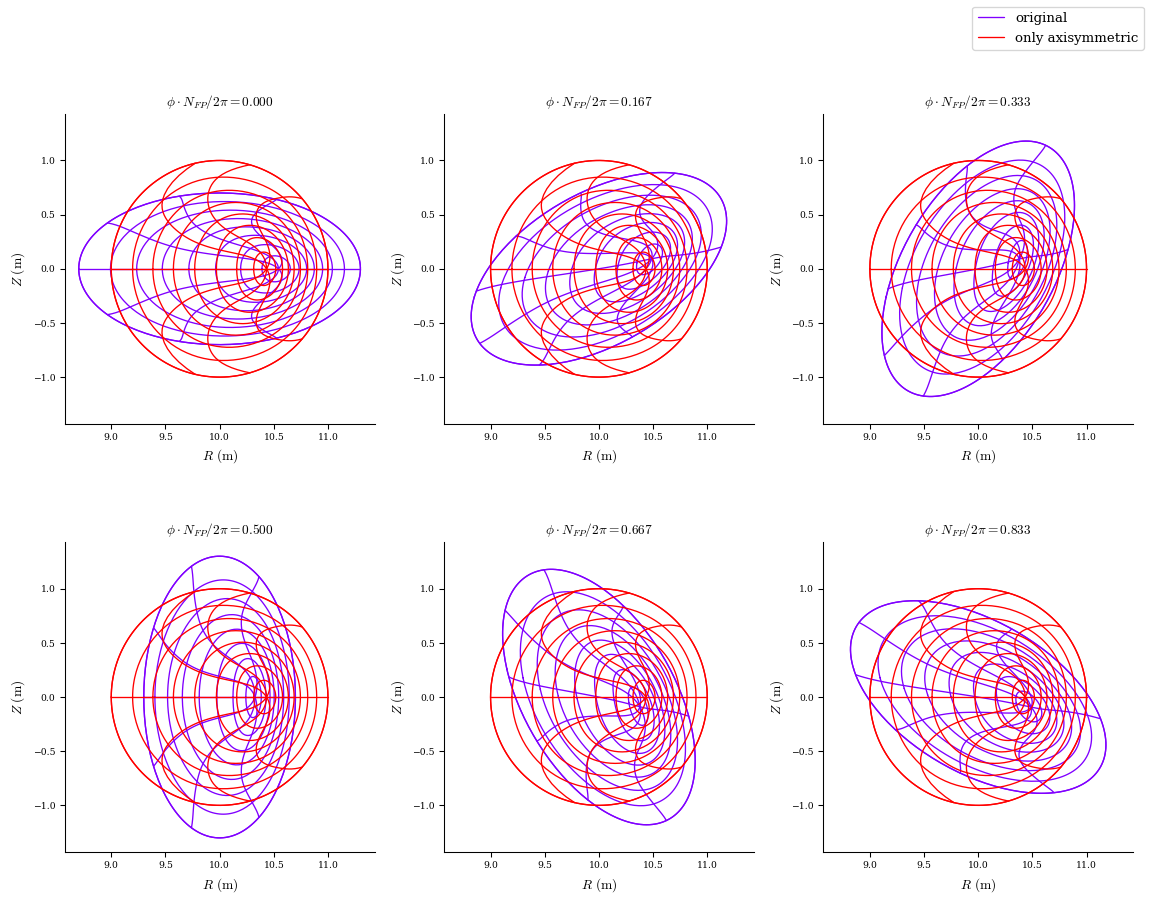

In [15]:
eq_poincare.change_resolution(N=0)
solve_step(eq_poincare, maxiter= 10, plot=True)

Building objective: force


Precomputing transforms
Timer: Precomputing transforms = 167 ms
Timer: Objective build = 193 ms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: fixed cross-section λ
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed axis R
Building objective: fixed axis Z
Building objective: fix mode R
Building objective: fix mode Z
Timer: Objective build = 398 ms
Timer: Linear constraint projection build = 505 ms
Number of parameters: 585
Number of objectives: 3420
Timer: Initializing the optimization = 1.11 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          6.782e-04                                    1.056e-04   
       1              2          6.

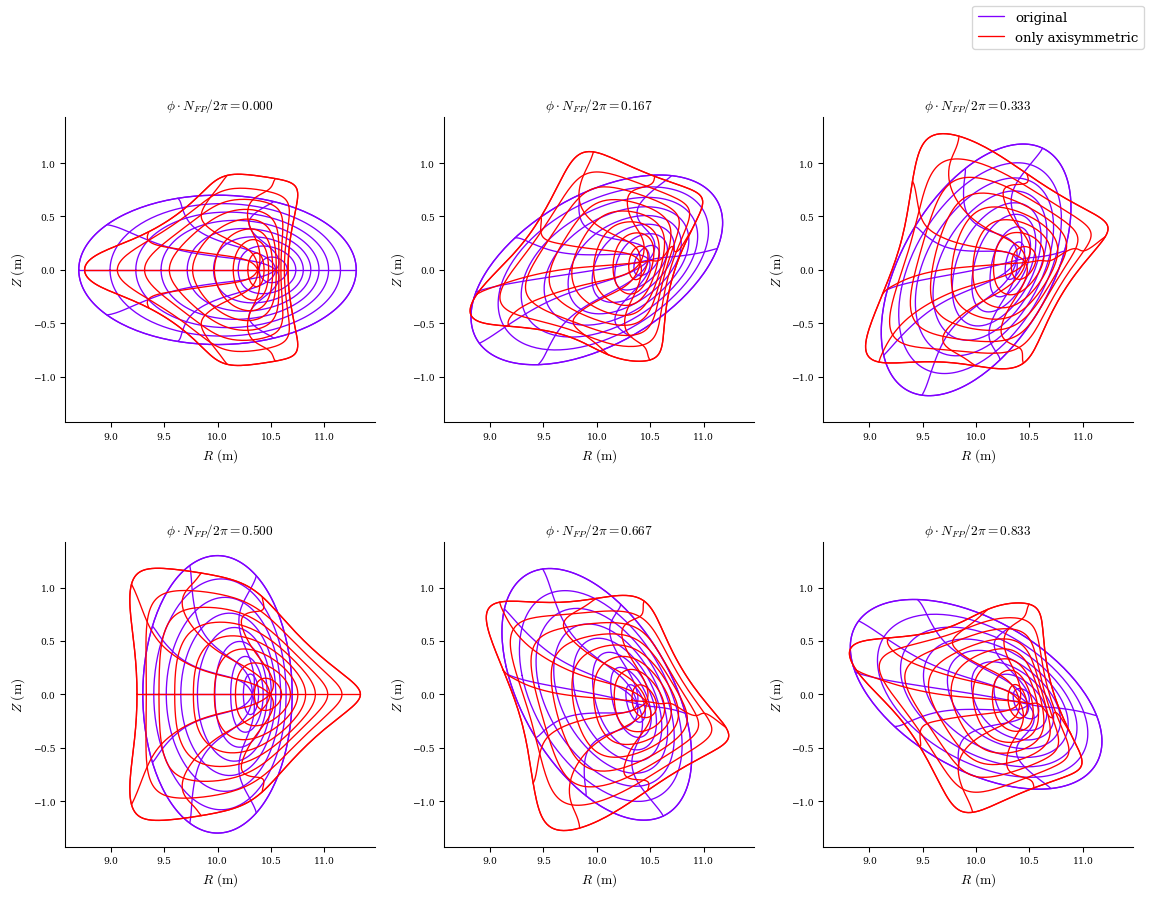

In [21]:
n = 1
eq_poincare.change_resolution(N = n, N_grid = 4*n)
solve_step(eq_poincare, maxiter=50, plot=True, ftol=0, gtol=0, xtol=0)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 102 ms
Timer: Objective build = 119 ms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: fixed cross-section λ
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed axis R
Building objective: fixed axis Z
Building objective: fix mode R
Building objective: fix mode Z
Timer: Objective build = 310 ms
Timer: Linear constraint projection build = 5.95 sec
Number of parameters: 1092
Number of objectives: 3420
Timer: Initializing the optimization = 6.46 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          4.285e-05                                    1.410e+00   
      

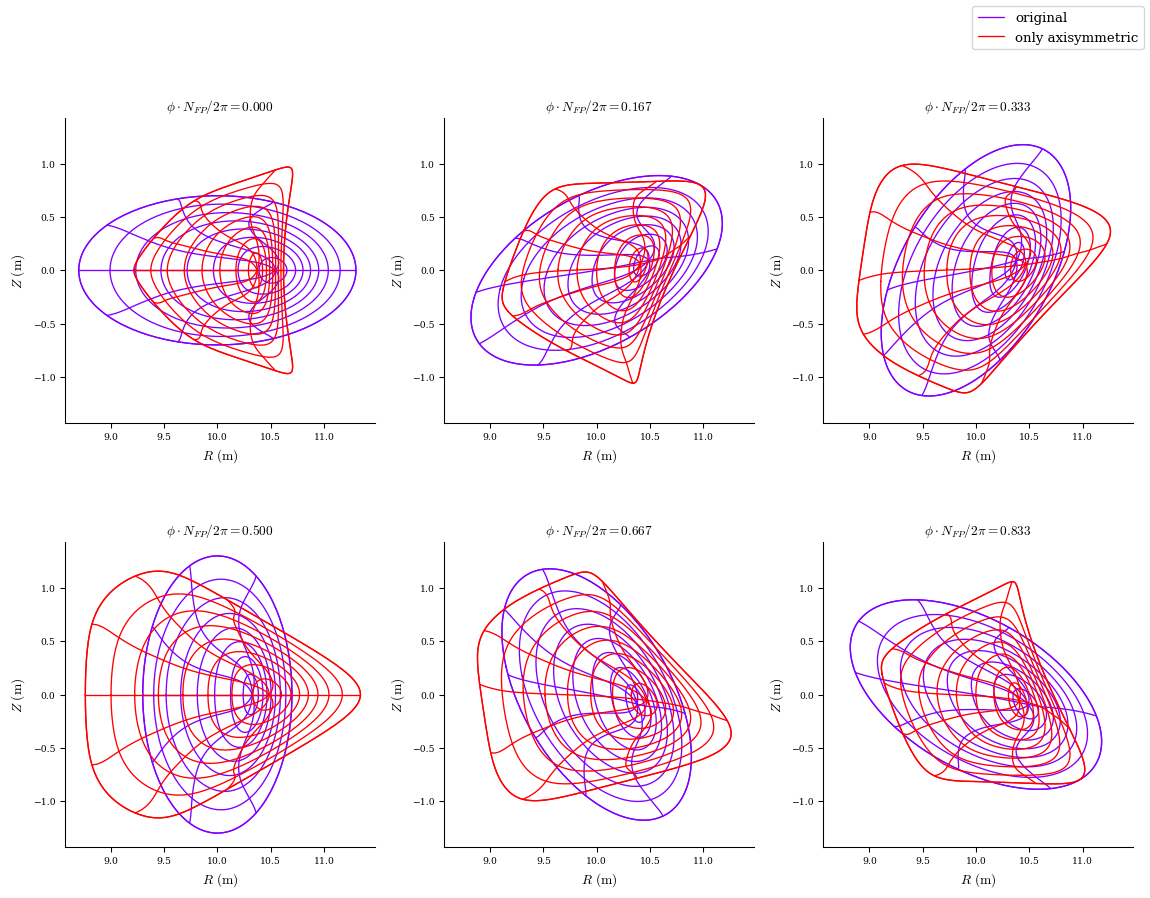

In [23]:
n = 2
eq_poincare.change_resolution(N = n, N_grid = 2*n)
solve_step(eq_poincare, maxiter=50, plot=True, ftol=0, gtol=0, xtol=0)

In [ ]:
for n in range(3,5):
    eq_poincare.change_resolution(N = n, N_grid = 2*n)
    solve_step(eq_poincare, plot=True)